In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import ipywidgets as widgets

import mplcursors

In [2]:
df = pd.read_csv('data/covid19_confirmados.csv', index_col= 'Country/Region')
df = df.drop(columns=['Lat','Long'])
df = df.groupby(by="Country/Region", sort=False).aggregate(np.sum)
df.columns = pd.to_datetime(df.columns)
dicc_nombres = {"Burma": "Myanmar",
                "Congo (Brazzaville)": "Congo",
                "Congo (Kinshasa)": "DR Congo",
                "Cote d'Ivoire": "Côte d'Ivoire",
                "Czechia": "Czech Republic (Czechia)",
                "Korea, South": "South Korea",
                "Saint Kitts and Nevis": "Saint Kitts & Nevis",
                "Saint Vincent and the Grenadines": "St. Vincent & Grenadines",
                "Sao Tome and Principe": "Sao Tome & Principe",
                "Taiwan*": "Taiwan",
                "US": "United States"
               }

df = df.rename(index=dicc_nombres)
df_pop_by_country = pd.read_csv('data/poblacion_mundial2020.csv', index_col='Country (or dependency)')
df_pop_by_country.index.name="Country/Region"
df2 = df_pop_by_country['Population (2020)']
df_confirmados = pd.merge(df,df2,how='inner', on="Country/Region")
df_confirmados = df_confirmados.rename(columns=lambda x: pd.to_datetime(x) if x!='Population (2020)' else x) 

In [3]:
def normalize_dfcovid(dataframe):
    dicc_nombres = {"Burma": "Myanmar",
                "Congo (Brazzaville)": "Congo",
                "Congo (Kinshasa)": "DR Congo",
                "Cote d'Ivoire": "Côte d'Ivoire",
                "Czechia": "Czech Republic (Czechia)",
                "Korea, South": "South Korea",
                "Saint Kitts and Nevis": "Saint Kitts & Nevis",
                "Saint Vincent and the Grenadines": "St. Vincent & Grenadines",
                "Sao Tome and Principe": "Sao Tome & Principe",
                "Taiwan*": "Taiwan",
                "US": "United States"
               }
    df = pd.read_csv('data/' + dataframe, index_col= 'Country/Region')
    df = df.drop(columns=['Lat','Long'])
    df = df.groupby(by="Country/Region", sort=False).aggregate(np.sum)
    df.columns = pd.to_datetime(df.columns)
    df = df.rename(index=dicc_nombres)
    
    df_pop_by_country = pd.read_csv('data/poblacion_mundial2020.csv', index_col='Country (or dependency)')
    df_pop_by_country.index.name="Country/Region"
    df2 = df_pop_by_country['Population (2020)']
    df3 = pd.merge(df,df2,how='inner', on="Country/Region")
    
    return df3

In [4]:
df_recuperados = normalize_dfcovid("covid19_recuperados.csv")
df_muertes = normalize_dfcovid("covid19_muertes.csv")

df_recuperados = df_recuperados.rename( columns= lambda x: pd.to_datetime(x) if x!='Population (2020)' else x)
df_muertes = df_muertes.rename( columns= lambda x: pd.to_datetime(x) if x!='Population (2020)' else x)

In [5]:
def tasa (date,df):
    df_aux = pd.DataFrame()
    df_aux['tasa'] = (df.loc[:,pd.Timestamp(date)].apply( lambda x: x*100000) )/ df.loc[:,'Population (2020)']
    return df_aux

In [6]:
url = "https://gist.githubusercontent.com/kintero/7d1db891401f56256c79/raw/a61f6d0dda82c3f04d2e6e76c3870552ef6cf0c6/paises.csv"
#info_country = pd.read_csv(url, sep=',', index_col=' name')
info_country = pd.read_csv(url, sep=',', index_col=' phone_code')

In [7]:
def tasa_rango_de_tiempo(date_start,date_end, df):
        df_aux = pd.DataFrame()
        df_aux['tasa'] = df.loc[:,pd.Timestamp(date_start) : pd.Timestamp(date_end)].sum(axis=1) * 100000/ df.loc[:,'Population (2020)']
        df_aux = pd.merge(df_aux,info_country,how='inner', on="Country/Region")
                
        df_aux['continente'].dropna()
        df_aux = df_aux.drop(columns=['phone_code'])
        
        return df_aux

In [8]:
info_country = info_country.drop(columns=['nombre',' nom',' iso3'])
info_country.rename(columns={" name":"Country/Region"," continente":"continente"," iso2":"iso2"},inplace = True)
info_country.loc["243", "Country/Region"] = "DR Congo"
info_country = info_country.reset_index().set_index("Country/Region")

#Se añado los datos de south sudan a mano ya que no se encontraba en la data donde se extraen los datos de código de los países
info_country.loc['South Sudan'] = ['211','SS', 'África']
info_country.insert(loc=3, column='size', value=50)

newnames = {
    "Cape Verde":"Cabo Verde",
    "Czech Republic":"Czech Republic (Czechia)",
    "Ivory Coast":"Côte d'Ivoire",
    "United States of America":"United States",
    "Macedonia":"North Macedonia",
    "Saint Kitts and Nevis":"Saint Kitts & Nevis",
    "Saint Vincent and the Grenadines":"St. Vincent & Grenadines",
    "Sao Tome and Principe": "Sao Tome & Principe",
    "Swaziland":"Eswatini",
    "East Timor":"Timor-Leste",
    "Estados Federados de":"Micronesia",
    "Vatican City State":"Holy See"
}

info_country = info_country.rename(index=newnames)
info_country.rename(columns={" phone_code":"phone_code"},inplace = True)

df_confirmados_extend = pd.merge(df_confirmados,info_country,how='inner', on="Country/Region")
df_muertes_extend = pd.merge(df_confirmados,info_country,how='inner', on="Country/Region")
df_recuperados_extend = pd.merge(df_confirmados,info_country,how='inner', on="Country/Region")

df_incidencias_enero_20 = tasa_rango_de_tiempo('2020-01-22','2020-01-31', df_confirmados_extend)
df_incidencias_enero_21 = tasa_rango_de_tiempo('2021-01-01','2021-01-31', df_confirmados_extend)
df_incidencias_enero_22 = tasa_rango_de_tiempo('2022-01-01','2022-01-31', df_confirmados_extend)

df_muertes_enero_20 = tasa_rango_de_tiempo('2020-01-22','2020-01-31', df_muertes_extend)
df_muertes_enero_21 = tasa_rango_de_tiempo('2021-01-01','2021-01-31', df_muertes_extend)
df_muertes_enero_22 = tasa_rango_de_tiempo('2022-01-01','2022-01-31', df_muertes_extend)

#Se establecen los colores de cada continente para graficar
colors = {'África':'black','América':'red','Asia':'yellow','Europa':'blue','Australia y Oceanía':'orange','Antártida':'purple'}

In [11]:
#Paises de la OCDE
OCDE_countries = ["United States","Mexico","Japan","Turkey","Germany","United Kingdom","France","Italy","South Korea","Spain","Canada","Poland","Australia","Chile","Netherlands",
"Belgium","Czech Republic (Czechia)","Greece","Sweden","Portugal","Hungary","Austria","Israel","Switzerland","Denmark","Finland","Norway","Slovakia","Ireland","New Zealand","Lithuania",
"Slovenia","Latvia","Estonia","Luxembourg","Iceland","Costa Rica"]

OCDE_countries = sorted(OCDE_countries)

Dropdown(description='País 1:', index=17, options=('Australia', 'Austria', 'Belgium', 'Canada', 'Chile', 'Cost…

Dropdown(description='País 2:', index=34, options=('Australia', 'Austria', 'Belgium', 'Canada', 'Chile', 'Cost…

Dropdown(description='Tipo de visualización:', options=('Casos acumulados', 'Casos nuevos'), value='Casos acum…

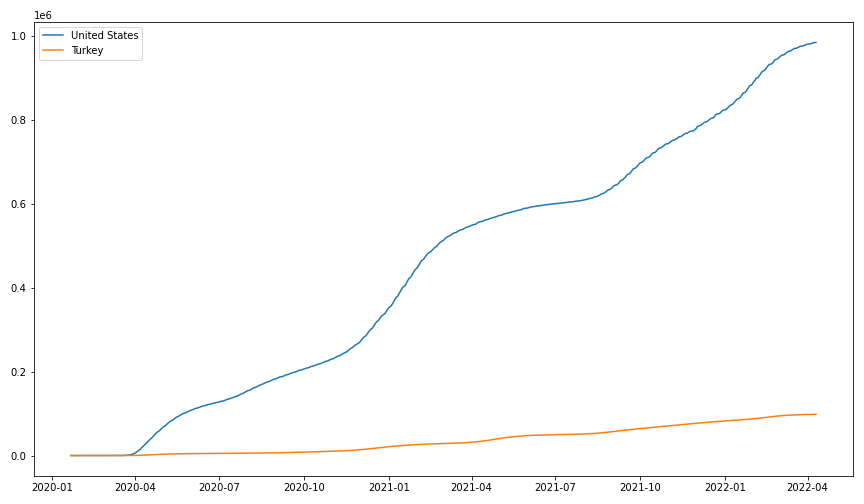

In [12]:
#%matplotlib notebook
%matplotlib ipympl

sel_slider = widgets.Dropdown(description="País 1:", 
                              options=OCDE_countries, value='Italy')

sel_slider2 = widgets.Dropdown(description="País 2:", 
                              options=OCDE_countries, value='Turkey')

sel_slider3 = widgets.Dropdown(description="Tipo de visualización:", 
                              options=['Casos acumulados' , 'Casos nuevos'], value='Casos acumulados')

display(sel_slider)
display(sel_slider2)
display(sel_slider3)
    

    
out1 = widgets.Output()
out2 = widgets.Output()
out3 = widgets.Output()


tab = widgets.Tab(children = [out1, out2, out3])
tab.set_title(0, 'Confirmados')
tab.set_title(1, 'Recuperados')
tab.set_title(2, 'Decesos')
display(tab)

with out1:


    fig, ax = plt.subplots(figsize=(12, 7), tight_layout=True)
    
    line = ax.plot(df_confirmados.loc['United States'][0:-1], label = 'United States')
    line2 = ax.plot(df_confirmados.loc['Turkey'][0:-1], label = 'Turkey')  
    
    def handlerT(change):
        if(change['new'] == 'Casos acumulados'):
            df_1 = df_confirmados.loc[sel_slider.value][0:-1].copy()
            df_2 = df_confirmados.loc[sel_slider2.value][0:-1].copy()
            
        elif(change['new'] == 'Casos nuevos' ):
            df_1 = df_confirmados.loc[sel_slider.value][0:-1].diff().copy()
            df_2 = df_confirmados.loc[sel_slider2.value][0:-1].diff().copy()
             
        line[0].set_ydata(df_1)
        line[0].set_label(sel_slider.value)
            
        line2[0].set_ydata(df_2)
        line2[0].set_label(sel_slider2.value)
        ax.legend()   
        
    def handler(change):
        df = df_confirmados.loc[change['new']][0:-1].copy()
        if(sel_slider3.value == 'Casos acumulados'):
            df = df_confirmados.loc[change['new']][0:-1].copy()
        
        elif(sel_slider3.value == 'Casos nuevos'):
            df = df_confirmados.loc[change['new']][0:-1].diff().copy()
            
        line[0].set_ydata(df)
        line[0].set_label(change['new'])
        ax.legend()
    
    def handler2(change):
        df = df_confirmados.loc[change['new']][0:-1].copy()
        if(sel_slider3.value == 'Casos acumulados'):
            df = df_confirmados.loc[change['new']][0:-1].copy()
        
        elif(sel_slider3.value == 'Casos nuevos'):
            df = df_confirmados.loc[change['new']][0:-1].diff().copy()
            
        line2[0].set_ydata(df)
        line2[0].set_label(change['new'])
        ax.legend()
        
        
    ax.legend()
    plt.show(fig)
    
with out2:

    fig2, ax2 = plt.subplots(figsize=(12, 7), tight_layout=True)
    
    line3 = ax2.plot(df_recuperados.loc['United States'][0:-1] , label = 'United States' )
    line4 = ax2.plot(df_recuperados.loc['Turkey'][0:-1], label = 'Turkey')
    
    def handlerR(change):
        if(change['new'] == 'Casos acumulados'):
            df_1 = df_recuperados.loc[sel_slider.value][0:-1].copy()
            df_2 = df_recuperados.loc[sel_slider2.value][0:-1].copy()
            
        elif(change['new'] == 'Casos nuevos' ):
            df_1 = df_recuperados.loc[sel_slider.value][0:-1].diff().copy()
            df_2 = df_recuperados.loc[sel_slider2.value][0:-1].diff().copy()
             
        line3[0].set_ydata(df_1)
        line3[0].set_label(sel_slider.value)
            
        line4[0].set_ydata(df_2)
        line4[0].set_label(sel_slider2.value)
        ax2.legend()
    
    def handler3(change):
        df = df_recuperados.loc[change['new']][0:-1].copy()
        if(sel_slider3.value == 'Casos acumulados'):
            df = df_recuperados.loc[change['new']][0:-1].copy()
        
        elif(sel_slider3.value == 'Casos nuevos'):
            df = df_recuperados.loc[change['new']][0:-1].diff().copy()
            
        line3[0].set_ydata(df)
        line3[0].set_label(change['new'])
        ax2.legend()
    
    def handler4(change):
        df = df_recuperados.loc[change['new']][0:-1].copy()
        if(sel_slider3.value == 'Casos acumulados'):
            df = df_recuperados.loc[change['new']][0:-1].copy()
        
        elif(sel_slider3.value == 'Casos nuevos'):
            df = df_recuperados.loc[change['new']][0:-1].diff().copy()
            
        line4[0].set_ydata(df)
        line4[0].set_label(change['new'])
        ax2.legend()
        
        
    ax2.legend()
    plt.show(fig2)



    
with out3:

    fig3, ax3 = plt.subplots(figsize=(12, 7), tight_layout=True)
    
    line5 = ax3.plot(df_muertes.loc['United States'][0:-1], label = 'United States')
    line6 = ax3.plot(df_muertes.loc['Turkey'][0:-1], label = 'Turkey')
    
    def handlerD(change):
        if(change['new'] == 'Casos acumulados'):
            df_1 = df_muertes.loc[sel_slider.value][0:-1].copy()
            df_2 = df_muertes.loc[sel_slider2.value][0:-1].copy()
            
        elif(change['new'] == 'Casos nuevos' ):
            df_1 = df_muertes.loc[sel_slider.value][0:-1].diff().copy()
            df_2 = df_muertes.loc[sel_slider2.value][0:-1].diff().copy()
             
        line5[0].set_ydata(df_1)
        line5[0].set_label(sel_slider.value)
            
        line6[0].set_ydata(df_2)
        line6[0].set_label(sel_slider2.value)
        ax3.legend()
    
    
    def handler5(change):
        df = df_muertes.loc[change['new']][0:-1].copy()
        if(sel_slider3.value == 'Casos acumulados'):
            df = df_muertes.loc[change['new']][0:-1].copy()
        
        elif(sel_slider3.value == 'Casos nuevos'):
            df = df_muertes.loc[change['new']][0:-1].diff().copy()
            
        line5[0].set_ydata(df)
        line5[0].set_label(change['new'])
        ax3.legend()
    
    def handler6(change):
        df = df_muertes.loc[change['new']][0:-1].copy()
        if(sel_slider3.value == 'Casos acumulados'):
            df = df_muertes.loc[change['new']][0:-1].copy()
        
        elif(sel_slider3.value == 'Casos nuevos'):
            df = df_muertes.loc[change['new']][0:-1].diff().copy()
            
        line6[0].set_ydata(df)
        line6[0].set_label(change['new'])
        ax3.legend()
    
        
    ax3.legend()    
    plt.show(fig3)



sel_slider.observe(handler , names='value')

sel_slider2.observe(handler2 ,names='value')
sel_slider.observe(handler3, names='value')
sel_slider2.observe(handler4, names='value')
sel_slider.observe(handler5, names='value')
sel_slider2.observe(handler6, names='value')

#Maneja cuando se cambia el tipo 'Acumulados' o 'Diario'
sel_slider3.observe(handlerT, names='value')
sel_slider3.observe(handlerR, names='value')
sel_slider3.observe(handlerD, names='value')